# 1. Define binning and model

In [1]:
import uproot
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import pyhf
import cabinetry
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

In [2]:
cabinetry.set_logging()

In [3]:
# Define the fitting range and number of bins, 'p_D_l'
start = 1.2 # for muons
end = 4.2
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

# Define the minimum bin counts
bin_threshold = 1


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
lepton_mode = 'ell'
training_variables = util.training_variables
variables = util.variables

columns=['__experiment__','__run__','__event__','__production__','B0_isContinuumEvent',
         'DecayMode', 'p_D_l', 'B_D_ReChi2','B0_mcPDG','B0_mcErrors','D_mcErrors','D_mcPDG',
         'D_M','D_genMotherPDG',f'{lepton_mode}_genMotherPDG', f'{lepton_mode}_mcPDG',
         f'{lepton_mode}_mcErrors',f'{lepton_mode}_pSig','B0_mcDaughter_0_PDG',
         'B0_mcDaughter_1_PDG', f'{lepton_mode}_genGMPDG',
         'D_K_pValue','D_pi1_pValue','D_pi2_pValue',
         'D_CMS_p',f'{lepton_mode}_CMS_p']+variables

In [4]:
# load generic MC15ri muon
files = ['MC15ri_mixed_1ab_korat_mu_1/mixed_1ab_mu_0.root:B0',
         #'MC15ri_mixed_1ab_korat_mu_1/mixed_1ab_mu_1.root:B0', 
         #'MC15ri_mixed_1ab_korat_mu_1/mixed_1ab_mu_2.root:B0', 
         #'MC15ri_charged_1ab_korat_mu_1/charged_1ab_mu_0.root:B0',
         #'MC15ri_charged_1ab_korat_mu_1/charged_1ab_mu_1.root:B0', 
         'MC15ri_charged_1ab_korat_mu_1/charged_1ab_mu_2.root:B0',]

temp = uproot.concatenate([f'../Samples/Generic_MC15ri/{f}' for f in files],
                        library="np",
                        #cut='DecayMode>0',
                        filter_branch=lambda branch: branch.name in columns)

In [5]:
df = pd.DataFrame(temp)

df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df.eval(f'p_D_l = D_CMS_p + {lepton_mode}_CMS_p', inplace=True)
df['D_daughter_pValue_min'] = df[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].min(axis=1)
df['D_daughter_pValue_mean'] = df[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].mean(axis=1)

# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

In [6]:
# signal region
cut_signal = 'signal_prob==largest_prob and signal_prob>0.8 and \
D_daughter_pValue_min>D_daughter_pValue_mean/100 and 1.84<D_M<1.9'
df_lgb=df_lgb.query(cut_signal)

cut_sr='1.855<D_M<1.885'

# apply the mva cut
df_cut_sr=df_lgb.query(cut_sr)
df_bestSelected_sr=df_cut_sr.loc[df_cut_sr.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df_sr, samples_sr=util.get_dataframe_samples(df_bestSelected_sr, 'ell', template=True, new=True)
# mpl=util.mpl(samples)
# ply=util.ply(df)

# construct templates and test data
templates_sr = {}
test_sr = []
for name in [r'$D\tau\nu$',r'$D^\ast\tau\nu$',r'$D\ell\nu$',r'$D^\ast\ell\nu$']:
    templates_sr[name] = samples_sr[name].sample(frac=0.6, random_state=0)
    test_sr.append(pd.concat([samples_sr[name], templates_sr[name]]).drop_duplicates(keep=False))

# D** tau nu
Dstst_tau_sr = pd.concat([samples_sr[r'$D^{\ast\ast}\tau\nu$_mixed'],samples_sr[r'$D^{\ast\ast}\tau\nu$_charged']])
templates_sr[r'$D^{\ast\ast}\tau\nu$'] = Dstst_tau_sr.sample(frac=0.6, random_state=0)
test_sr.append(pd.concat([Dstst_tau_sr, templates_sr[r'$D^{\ast\ast}\tau\nu$']]).drop_duplicates(keep=False))

# D** ell nu resonants
Dstst_l_res_sr = pd.concat([samples_sr[r'res_$D^{\ast\ast}\ell\nu$_mixed'],samples_sr[r'res_$D^{\ast\ast}\ell\nu$_charged']])
templates_sr[r'res_$D^{\ast\ast}\ell\nu$'] = Dstst_l_res_sr.sample(frac=0.6, random_state=0)
test_sr.append(pd.concat([Dstst_l_res_sr, templates_sr[r'res_$D^{\ast\ast}\ell\nu$']]).drop_duplicates(keep=False))

# D** ell nu non-res
Dstst_l_non_sr = pd.concat([samples_sr[r'nonres_$D^{\ast\ast}\ell\nu$_mixed'],
                         samples_sr[r'nonres_$D^{\ast\ast}\ell\nu$_charged'],])
Dstst_l_non_temp_sr = Dstst_l_non_sr.sample(frac=0.6, random_state=0)
Dstst_l_non_test_sr = pd.concat([Dstst_l_non_sr, Dstst_l_non_temp_sr]).drop_duplicates(keep=False)
test_sr.append(Dstst_l_non_test_sr)

# special treatment for the gap modes
Dstst_gap_temp_sr = samples_sr[r'gap_$D^{\ast\ast}\ell\nu$_mixed'].sample(frac=0.6, random_state=0)
Dstst_gap_test_sr = pd.concat([Dstst_gap_temp_sr, samples_sr[r'gap_$D^{\ast\ast}\ell\nu$_mixed']]).drop_duplicates(keep=False)
Dstst_gap_test_sr['__weight__'] = 1
test_sr.append(Dstst_gap_test_sr)

templates_sr[r'non_gap_$D^{\ast\ast}\ell\nu$'] = pd.concat([Dstst_l_non_temp_sr,Dstst_gap_temp_sr])

# Fake D
fakeD_temp_sr = samples_sr['bkg_fakeD'].sample(frac=0.6, random_state=0)
fakeD_test_sr = pd.concat([fakeD_temp_sr, samples_sr[r'bkg_fakeD']]).drop_duplicates(keep=False)
templates_sr['bkg_fakeD'] = fakeD_temp_sr
test_sr.append(fakeD_test_sr)

data_sr = pd.concat(test_sr)

for name, df in templates_sr.items():
    df['__weight__'] = 2/3
    print(name, len(df))

$D\tau\nu$ 646
$D^\ast\tau\nu$ 357
$D\ell\nu$ 13457
$D^\ast\ell\nu$ 9101
$D^{\ast\ast}\tau\nu$ 181
res_$D^{\ast\ast}\ell\nu$ 5258
non_gap_$D^{\ast\ast}\ell\nu$ 1032
bkg_fakeD 6308


In [9]:
# D sideband left
cut_Dlsb='1.84<D_M<1.855'

# apply the mva cut
df_cut_Dlsb=df_lgb.query(cut_Dlsb)
df_bestSelected_Dlsb=df_cut_Dlsb.loc[df_cut_Dlsb.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df_Dlsb, samples_Dlsb=util.get_dataframe_samples(df_bestSelected_Dlsb, 'ell', template=True, new=True)
# mpl=util.mpl(samples)
# ply=util.ply(df)

# construct templates and test data
templates_Dlsb = {}

# Fake D
templates_Dlsb['bkg_fakeD'] = samples_Dlsb['bkg_fakeD'].sample(frac=0.6, random_state=0)
fakeD_test_Dlsb = pd.concat([templates_Dlsb['bkg_fakeD'], samples_Dlsb[r'bkg_fakeD']]).drop_duplicates(keep=False)

data_Dlsb = fakeD_test_Dlsb

for name, df in templates_Dlsb.items():
    df['__weight__'] = 2/3 * 0.9856
    print(name, len(df))

bkg_fakeD 3200


In [10]:
# D sideband right
cut_Drsb='1.885<D_M<1.9'

# apply the mva cut
df_cut_Drsb=df_lgb.query(cut_Drsb)
df_bestSelected_Drsb=df_cut_Drsb.loc[df_cut_Drsb.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df_Drsb, samples_Drsb=util.get_dataframe_samples(df_bestSelected_Drsb, 'ell', template=True, new=True)
# mpl=util.mpl(samples)
# ply=util.ply(df)

# construct templates and test data
templates_Drsb = {}

# Fake D
templates_Drsb['bkg_fakeD'] = samples_Drsb['bkg_fakeD'].sample(frac=0.6, random_state=0)
fakeD_test_Drsb = pd.concat([templates_Drsb['bkg_fakeD'], samples_Drsb[r'bkg_fakeD']]).drop_duplicates(keep=False)

data_Drsb = fakeD_test_Drsb

for name, df in templates_Drsb.items():
    df['__weight__'] = 2/3 * 1.0447
    print(name, len(df))

bkg_fakeD 3019


In [11]:
# Use sideband Fake D as the template for the signal region
templates_sr['bkg_fakeD'] = pd.concat([templates_Dlsb['bkg_fakeD'], templates_Drsb['bkg_fakeD']])

In [12]:
# Create template histograms
t_histograms_sr = {}
t_staterr_sr = {}
for name, template in templates_sr.items():
    
    (counts_sr, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__'])
    
    (staterr_squared_sr, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__']**2)
    t_staterr_sr[name] = np.sqrt(staterr_squared_sr).T
    t_histograms_sr[name] = counts_sr.T
    
# Create data histogram
(d_histogram_sr, xedges, yedges) = np.histogram2d(data_sr['B0_CMS3_weMissM2'], 
                                               data_sr['p_D_l'],
                                               bins=[MM2_bins, p_D_l_bins],
                                               weights=data_sr['__weight__'])
d_histogram_sr = d_histogram_sr.T
    
indices_threshold_sr = np.where(np.sum(list(t_histograms_sr.values()),axis=0) >= bin_threshold)
template_flat_sr = {name:list(t[indices_threshold_sr]) for name,t in t_histograms_sr.items()}
staterr_flat_sr = {name:list(se[indices_threshold_sr]) for name,se in t_staterr_sr.items()}
# data = counts.ravel().to_list()
data_flat_sr = list(d_histogram_sr[indices_threshold_sr])

# edges = np.linspace(0, len(data), len(data)+1)
# truth = np.array([int(np.sum(t0)) for t0 in test0])


In [13]:
t_histograms_Dlsb = {}
t_staterr_Dlsb = {}
for name, template in templates_Dlsb.items():
    
    (counts_Dlsb, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__'])
    
    (staterr_squared_Dlsb, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__']**2)
    t_staterr_Dlsb[name] = np.sqrt(staterr_squared_Dlsb).T
    t_histograms_Dlsb[name] = counts_Dlsb.T
    
# Create data histogram
(d_histogram_Dlsb, xedges, yedges) = np.histogram2d(data_Dlsb['B0_CMS3_weMissM2'], 
                                               data_Dlsb['p_D_l'],
                                               bins=[MM2_bins, p_D_l_bins],
                                               weights=data_Dlsb['__weight__'])
d_histogram_Dlsb = d_histogram_Dlsb.T
    
indices_threshold_Dlsb = np.where(np.sum(list(t_histograms_Dlsb.values()),axis=0) >= bin_threshold)
template_flat_Dlsb = {name:list(t[indices_threshold_Dlsb]) for name,t in t_histograms_Dlsb.items()}
staterr_flat_Dlsb = {name:list(se[indices_threshold_Dlsb]) for name,se in t_staterr_Dlsb.items()}
# data = counts.ravel().to_list()
data_flat_Dlsb = list(d_histogram_Dlsb[indices_threshold_Dlsb])

In [14]:
t_histograms_Drsb = {}
t_staterr_Drsb = {}
for name, template in templates_Drsb.items():
    
    (counts_Drsb, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__'])
    
    (staterr_squared_Drsb, xedges, yedges) = np.histogram2d(template['B0_CMS3_weMissM2'], 
                                                        template['p_D_l'],
                                                        bins=[MM2_bins, p_D_l_bins],
                                                        weights=template['__weight__']**2)
    t_staterr_Drsb[name] = np.sqrt(staterr_squared_Drsb).T
    t_histograms_Drsb[name] = counts_Drsb.T
    
# Create data histogram
(d_histogram_Drsb, xedges, yedges) = np.histogram2d(data_Drsb['B0_CMS3_weMissM2'], 
                                               data_Drsb['p_D_l'],
                                               bins=[MM2_bins, p_D_l_bins],
                                               weights=data_Drsb['__weight__'])
d_histogram_Drsb = d_histogram_Drsb.T
    
indices_threshold_Drsb = np.where(np.sum(list(t_histograms_Drsb.values()),axis=0) >= bin_threshold)
template_flat_Drsb = {name:list(t[indices_threshold_Drsb]) for name,t in t_histograms_Drsb.items()}
staterr_flat_Drsb = {name:list(se[indices_threshold_Drsb]) for name,se in t_staterr_Drsb.items()}
# data = counts.ravel().to_list()
data_flat_Drsb = list(d_histogram_Drsb[indices_threshold_Drsb])

# 2. Create a pyhf workspace

In [15]:
workspace_path = "R_D_2d_workspace_withDsideband_ell.json"
spec = cabinetry.workspace.load(workspace_path)
print(json.dumps(spec, sort_keys=True, indent=4))

{
    "channels": [
        {
            "name": "muon",
            "samples": [
                {
                    "data": [
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.6666666666666666,
                        0.6666666666666666,
                        1.3333333333333333,
                        0.0,
                        1.3333333333333333,
                        0.0,
                        0.6666666666666666,
                        0.6666666666666666,
                        2.0,
                        0.6666666666666666,
                        0.6666666666666666,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.6666666666666666,
                        0.0,
         

In [16]:
# update templates and data in the workspace
# signal region
names_sr = list(template_flat_sr.keys())
for i, sample_SignalRegion in enumerate(spec['channels'][0]['samples']):
    sample_SignalRegion['name'] = names_sr[i]
    sample_SignalRegion['data'] = template_flat_sr[names_sr[i]]
    for m in sample_SignalRegion['modifiers']:
        if m['type']=='staterror':
            m['data'] = staterr_flat_sr[names_sr[i]]
            m['name'] = 'staterror_signal_region'
        if m['type']=="normfactor":
            m['name'] = names_sr[i]+'_norm'

# D sideband
# for i in [1,2]:
#     Dsideband = spec['channels'][i]['samples'][0]
#     if i==1:
#         Dsideband['data']=template_flat_Dlsb['bkg_fakeD']
#         Dsideband['name']='D_sideband_Left'
#     else:
#         Dsideband['data']=template_flat_Drsb['bkg_fakeD']
#         Dsideband['name']='D_sideband_Right'
#     for m in Dsideband['modifiers']:
#         if m['type']=='staterror' and i==1:
#             m['data'] = staterr_flat_Dlsb['bkg_fakeD']
#             m['name'] = 'staterror_Dsideband_Left'
#         if m['type']=='staterror' and i==2:
#             m['data'] = staterr_flat_Drsb['bkg_fakeD']
#             m['name'] = 'staterror_Dsideband_Right'
#         if m['type']=="normfactor":
#             m['name'] = 'bkg_fakeD_norm'

            
spec['observations'][0]['data']=data_flat_sr
# spec['observations'][1]['data']=data_flat_Dlsb
# spec['observations'][2]['data']=data_flat_Drsb

for i, par in enumerate(spec["measurements"][0]["config"]["parameters"]):
    par['name']=names_sr[i]+'_norm'
    
spec["measurements"][0]["config"]['poi']="$D\\tau\\nu$_norm"

print(json.dumps(spec, sort_keys=True, indent=4))

# cabinetry.workspace.save(spec, workspace_path)

DEBUG - cabinetry.workspace - saving workspace to R_D_2d_workspace_withDsideband_ell.json


{
    "channels": [
        {
            "name": "muon",
            "samples": [
                {
                    "data": [
                        0.0,
                        0.0,
                        0.0,
                        0.6666666666666666,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.6666666666666666,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.0,
                        0.6666666666666666,
                        0.0,
                        0.0,
                        0.6666666666666666,
                        0.0,
                        0.

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier non_gap_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (723 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


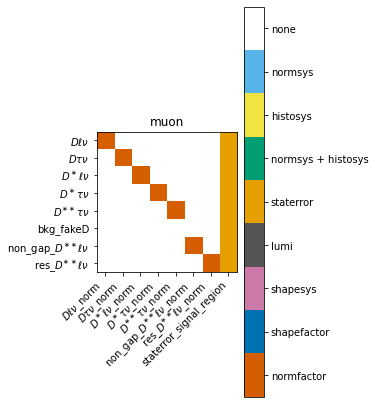

In [17]:
cabinetry.visualize.modifier_grid(pyhf.Workspace(spec).model())

In [18]:
model, data = cabinetry.model_utils.model_and_data(spec)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier $D\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^\ast\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier $D^{\ast\ast}\tau\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier non_gap_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier res_$D^{\ast\ast}\ell\nu$_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_signal_region (723 new nuisance parameters)


In [3]:
model, data = cabinetry.model_utils.model_and_data(spec)

DEBUG - cabinetry.model_utils - total stdev is [[0.927, 1.94, 1.77, 1.76, 2.21, 2.44, ..., 0.943, 4.28, 5.62, 5.85, 4.37]]
DEBUG - cabinetry.model_utils - total stdev per channel is [212]
INFO - cabinetry.visualize.utils - saving figure as figures/muon_prefit.pdf


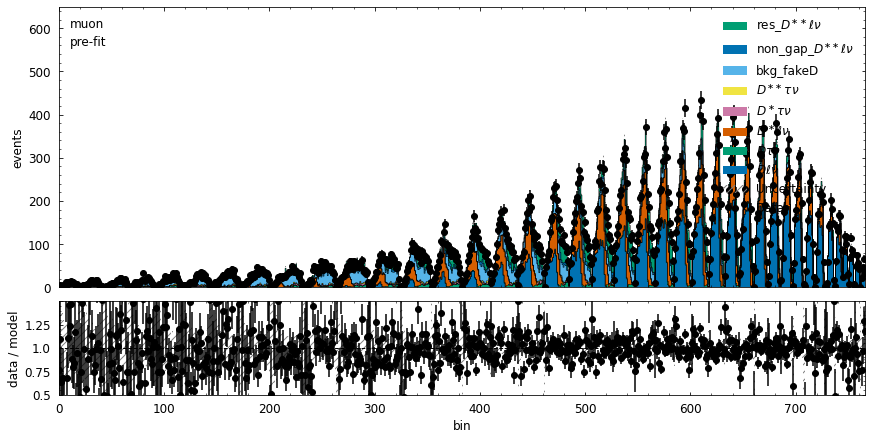

In [18]:
model_pred_prefit = cabinetry.model_utils.prediction(model)
#plt.figure(figsize=(16,6))
dms = cabinetry.visualize.data_mc(model_pred_prefit, data, log_scale=False)
for i in dms:
    i['figure'].set_figwidth(12)

# 3. MLE

In [ ]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

In [ ]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])
# gap * 1.5

In [ ]:
%%time
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])
# gap * 0.5

In [19]:
%%time
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3072                       │      Nfcn = 271956, Ngrad = 12       │
│ EDM = 0.0001 (Goal: 0.0002)      │           time = 170.9 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   

INFO - cabinetry.fit - staterror_signal_region[81]        =  0.6035 +/- 0.2036
INFO - cabinetry.fit - staterror_signal_region[82]        =  0.8949 +/- 0.1821
INFO - cabinetry.fit - staterror_signal_region[83]        =  0.8986 +/- 0.2152
INFO - cabinetry.fit - staterror_signal_region[84]        =  0.5902 +/- 0.2373
INFO - cabinetry.fit - staterror_signal_region[85]        =  0.8869 +/- 0.2140
INFO - cabinetry.fit - staterror_signal_region[86]        =  1.2971 +/- 0.2161
INFO - cabinetry.fit - staterror_signal_region[87]        =  0.8220 +/- 0.2110
INFO - cabinetry.fit - staterror_signal_region[88]        =  1.0710 +/- 0.2039
INFO - cabinetry.fit - staterror_signal_region[89]        =  1.0874 +/- 0.2538
INFO - cabinetry.fit - staterror_signal_region[90]        =  1.1430 +/- 0.2855
INFO - cabinetry.fit - staterror_signal_region[91]        =  0.8847 +/- 0.2007
INFO - cabinetry.fit - staterror_signal_region[92]        =  0.6094 +/- 0.2655
INFO - cabinetry.fit - staterror_signal_region[93]  

INFO - cabinetry.fit - staterror_signal_region[185]       =  0.7734 +/- 0.1777
INFO - cabinetry.fit - staterror_signal_region[186]       =  0.8269 +/- 0.1841
INFO - cabinetry.fit - staterror_signal_region[187]       =  0.8188 +/- 0.1914
INFO - cabinetry.fit - staterror_signal_region[188]       =  0.9255 +/- 0.1764
INFO - cabinetry.fit - staterror_signal_region[189]       =  1.1351 +/- 0.1701
INFO - cabinetry.fit - staterror_signal_region[190]       =  0.9550 +/- 0.1824
INFO - cabinetry.fit - staterror_signal_region[191]       =  1.1485 +/- 0.1739
INFO - cabinetry.fit - staterror_signal_region[192]       =  0.9482 +/- 0.1475
INFO - cabinetry.fit - staterror_signal_region[193]       =  0.8896 +/- 0.1560
INFO - cabinetry.fit - staterror_signal_region[194]       =  1.1521 +/- 0.1980
INFO - cabinetry.fit - staterror_signal_region[195]       =  0.7979 +/- 0.1390
INFO - cabinetry.fit - staterror_signal_region[196]       =  0.8931 +/- 0.1792
INFO - cabinetry.fit - staterror_signal_region[197] 

INFO - cabinetry.fit - staterror_signal_region[289]       =  0.3177 +/- 0.6878
INFO - cabinetry.fit - staterror_signal_region[290]       =  0.6890 +/- 0.2857
INFO - cabinetry.fit - staterror_signal_region[291]       =  0.9990 +/- 0.2579
INFO - cabinetry.fit - staterror_signal_region[292]       =  1.2355 +/- 0.1957
INFO - cabinetry.fit - staterror_signal_region[293]       =  1.5447 +/- 0.2248
INFO - cabinetry.fit - staterror_signal_region[294]       =  0.9100 +/- 0.1588
INFO - cabinetry.fit - staterror_signal_region[295]       =  0.8968 +/- 0.1254
INFO - cabinetry.fit - staterror_signal_region[296]       =  1.1116 +/- 0.1562
INFO - cabinetry.fit - staterror_signal_region[297]       =  1.0009 +/- 0.1141
INFO - cabinetry.fit - staterror_signal_region[298]       =  0.9180 +/- 0.1113
INFO - cabinetry.fit - staterror_signal_region[299]       =  0.9781 +/- 0.1116
INFO - cabinetry.fit - staterror_signal_region[300]       =  0.9053 +/- 0.1018
INFO - cabinetry.fit - staterror_signal_region[301] 

INFO - cabinetry.fit - staterror_signal_region[393]       =  1.0896 +/- 0.1237
INFO - cabinetry.fit - staterror_signal_region[394]       =  1.0464 +/- 0.1246
INFO - cabinetry.fit - staterror_signal_region[395]       =  0.9966 +/- 0.1406
INFO - cabinetry.fit - staterror_signal_region[396]       =  1.0378 +/- 0.1739
INFO - cabinetry.fit - staterror_signal_region[397]       =  0.7304 +/- 0.4551
INFO - cabinetry.fit - staterror_signal_region[398]       =  0.8894 +/- 0.1599
INFO - cabinetry.fit - staterror_signal_region[399]       =  1.1536 +/- 0.1803
INFO - cabinetry.fit - staterror_signal_region[400]       =  1.0245 +/- 0.1388
INFO - cabinetry.fit - staterror_signal_region[401]       =  0.9489 +/- 0.1148
INFO - cabinetry.fit - staterror_signal_region[402]       =  0.9051 +/- 0.0986
INFO - cabinetry.fit - staterror_signal_region[403]       =  0.9458 +/- 0.0918
INFO - cabinetry.fit - staterror_signal_region[404]       =  0.9923 +/- 0.0912
INFO - cabinetry.fit - staterror_signal_region[405] 

INFO - cabinetry.fit - staterror_signal_region[497]       =  0.9513 +/- 0.0565
INFO - cabinetry.fit - staterror_signal_region[498]       =  0.9575 +/- 0.0631
INFO - cabinetry.fit - staterror_signal_region[499]       =  0.9696 +/- 0.0690
INFO - cabinetry.fit - staterror_signal_region[500]       =  0.9494 +/- 0.0746
INFO - cabinetry.fit - staterror_signal_region[501]       =  1.1096 +/- 0.0879
INFO - cabinetry.fit - staterror_signal_region[502]       =  1.1270 +/- 0.0928
INFO - cabinetry.fit - staterror_signal_region[503]       =  0.8570 +/- 0.0925
INFO - cabinetry.fit - staterror_signal_region[504]       =  1.0812 +/- 0.1069
INFO - cabinetry.fit - staterror_signal_region[505]       =  0.9545 +/- 0.1227
INFO - cabinetry.fit - staterror_signal_region[506]       =  0.9789 +/- 0.1299
INFO - cabinetry.fit - staterror_signal_region[507]       =  1.1060 +/- 0.2901
INFO - cabinetry.fit - staterror_signal_region[508]       =  1.3075 +/- 0.1514
INFO - cabinetry.fit - staterror_signal_region[509] 

INFO - cabinetry.fit - staterror_signal_region[601]       =  1.0458 +/- 0.0528
INFO - cabinetry.fit - staterror_signal_region[602]       =  1.0074 +/- 0.0569
INFO - cabinetry.fit - staterror_signal_region[603]       =  0.9419 +/- 0.0782
INFO - cabinetry.fit - staterror_signal_region[604]       =  0.9251 +/- 0.0899
INFO - cabinetry.fit - staterror_signal_region[605]       =  1.0311 +/- 0.1154
INFO - cabinetry.fit - staterror_signal_region[606]       =  0.9710 +/- 0.2474
INFO - cabinetry.fit - staterror_signal_region[607]       =  0.9354 +/- 0.1627
INFO - cabinetry.fit - staterror_signal_region[608]       =  0.9761 +/- 0.0989
INFO - cabinetry.fit - staterror_signal_region[609]       =  0.9453 +/- 0.0869
INFO - cabinetry.fit - staterror_signal_region[610]       =  0.9683 +/- 0.0754
INFO - cabinetry.fit - staterror_signal_region[611]       =  0.9126 +/- 0.0687
INFO - cabinetry.fit - staterror_signal_region[612]       =  0.9338 +/- 0.0576
INFO - cabinetry.fit - staterror_signal_region[613] 

INFO - cabinetry.fit - staterror_signal_region[705]       =  0.9662 +/- 0.0988
INFO - cabinetry.fit - staterror_signal_region[706]       =  0.8599 +/- 0.1678
INFO - cabinetry.fit - staterror_signal_region[707]       =  0.3434 +/- 0.6892
INFO - cabinetry.fit - staterror_signal_region[708]       =  0.7995 +/- 0.2803
INFO - cabinetry.fit - staterror_signal_region[709]       =  1.0412 +/- 0.1193
INFO - cabinetry.fit - staterror_signal_region[710]       =  0.9394 +/- 0.1043
INFO - cabinetry.fit - staterror_signal_region[711]       =  1.0666 +/- 0.1136
INFO - cabinetry.fit - staterror_signal_region[712]       =  0.8798 +/- 0.1160
INFO - cabinetry.fit - staterror_signal_region[713]       =  1.0905 +/- 0.3452
INFO - cabinetry.fit - staterror_signal_region[714]       =  1.0008 +/- 0.4457
INFO - cabinetry.fit - staterror_signal_region[715]       =  0.9896 +/- 0.1617
INFO - cabinetry.fit - staterror_signal_region[716]       =  1.0336 +/- 0.1223
INFO - cabinetry.fit - staterror_signal_region[717] 

CPU times: user 4min 49s, sys: 6.88 s, total: 4min 56s
Wall time: 4min 35s


In [ ]:
%%time
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
fit_results = cabinetry.fit.fit(model=model, data=data)#, minos=model.config.parameters[:7])

In [ ]:
%%time
pyhf.set_backend('numpy','scipy')
parameters = pyhf.infer.mle.fit(data=data, pdf=model)
fit_results = cabinetry.fit.fit(model=model, data=data,init_pars=list(parameters),)
                                #minos=model.config.parameters[:7])

In [ ]:
post_fit_model=cabinetry.model_utils.prediction(model, fit_results=fit_results)

In [ ]:
cabinetry.tabulate.yields(post_fit_model,data,per_bin=False,per_channel=True)

In [28]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

$D\ell\nu$: 0.983 +/- 0.026
$D\tau\nu$: 0.957 +/- 0.057
$D^\ast\ell\nu$: 1.063 +/- 0.056
$D^\ast\tau\nu$: 1.077 +/- 0.123
$D^{\ast\ast}\ell\nu$: 1.016 +/- 0.081
$D^{\ast\ast}\tau\nu$: 1.013 +/- 0.068
staterror_signal_region[0]: 0.000 +/- 8.524
staterror_signal_region[1]: 1.022 +/- 0.700
staterror_signal_region[2]: 0.993 +/- 0.690
staterror_signal_region[3]: 0.701 +/- 0.491
staterror_signal_region[4]: 2.022 +/- 0.703
staterror_signal_region[5]: 1.478 +/- 0.350
staterror_signal_region[6]: 0.503 +/- 0.205
staterror_signal_region[7]: 0.932 +/- 0.234
staterror_signal_region[8]: 0.696 +/- 0.247
staterror_signal_region[9]: 0.766 +/- 0.157
staterror_signal_region[10]: 0.802 +/- 0.147
staterror_signal_region[11]: 0.910 +/- 0.144
staterror_signal_region[12]: 0.827 +/- 0.139
staterror_signal_region[13]: 0.685 +/- 0.485
staterror_signal_region[14]: 0.685 +/- 0.346
staterror_signal_region[15]: 0.445 +/- 0.313
staterror_signal_region[16]: 1.283 +/- 0.405
staterror_signal_region[17]: 1.163 +/- 0.314


INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


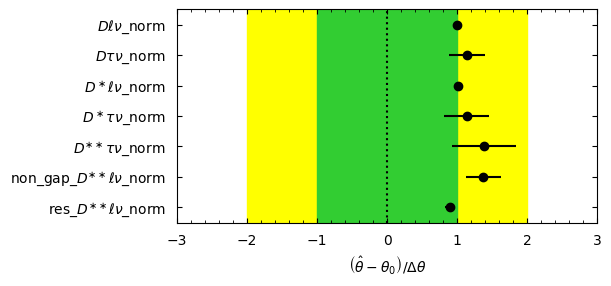

In [20]:
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


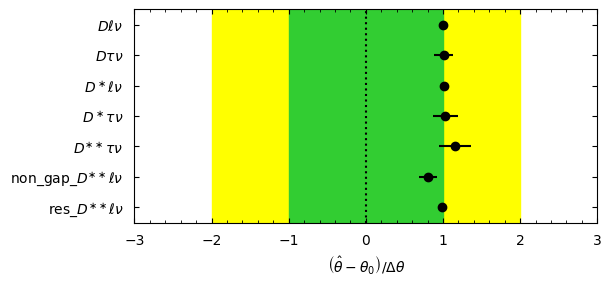

In [12]:
# gap * 0.5
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


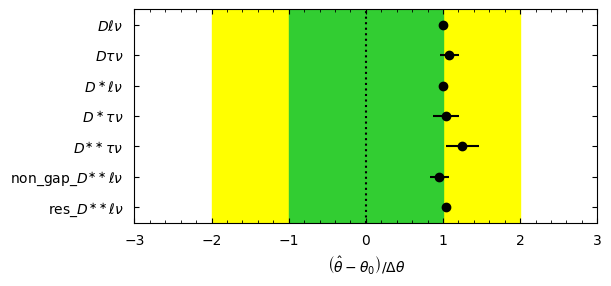

In [19]:
# gap * 1.5
cabinetry.visualize.pulls(fit_results)

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


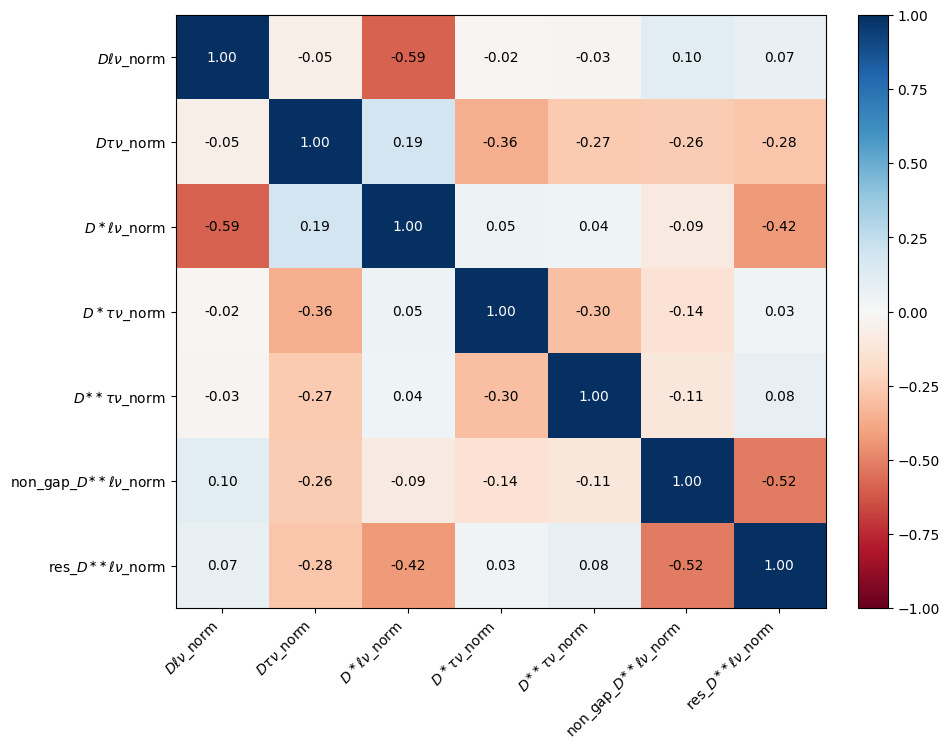

In [21]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.3)

In [31]:
# model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, log_scale=False)

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [ ]:
templates = np.array([s['data'] for s in electron_channel['samples']])
counts=np.sum(test0,axis=0).reshape(41,47)

start = 0.8
end = 4.2
num_bins = 40
yedges = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -1.1
end = 8.6
num_bins = 50
xedges = np.linspace(start, end, num_bins + 1)

templates_2d = [t.reshape(counts.shape) for t in templates]
data_2d = counts

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,1.5],direction='p_D_l',plot_with='pltbar')

In [ ]:
util.mpl_projection_residual(m4, templates_2d, data_2d, edges=[xedges,yedges], slices=[3,2.5],direction='mm2',plot_with='pltbar')

# 4. Asimov and Toys

In [ ]:
asimov_data = cabinetry.model_utils.asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

In [5]:
pyhf.set_backend("jax", pyhf.optimize.minuit_optimizer(maxiter=1000000))
poi = model.config.parameters[:6]

WARNING - jax._src.xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
pyhf.set_backend("numpy", 'minuit')

# init the norm parameters
par_bounds = model.config.suggested_bounds()
fixed_params = model.config.suggested_fixed()
poi = model.config.parameters[:6] # same as model.config.par_order

In [5]:
from multiprocessing import Pool

def fit_toys(toy):
    try:
        return cabinetry.fit.fit(model=model, data=toy)
        # return pyhf.infer.mle.fit(toy, model,return_uncertainties=True)
    except pyhf.exceptions.FailedMinimization:
        pass

def generate_toys(init_norm=None, n_toys=100, poi=poi,seed=0):
    # initialize the generator and model
    toy_pars = model.config.suggested_init()
    rng = np.random.default_rng(seed)
    toy_pars[:len(poi)] = rng.random(len(poi))
    if type(init_norm) in [int, float]:
        toy_pars[:len(poi)] = [init_norm]*len(poi)
    # print(f"init parameters: {list(zip(model.config.parameters, [round(n,2) for n in toy_pars]))}")

    # make the pdfs
    pdf_toy = model.make_pdf(pyhf.tensorlib.astensor(toy_pars))

    # draws samples from the pdf shape given the number of samples N=(10000,)
    return pdf_toy.sample((n_toys,)), toy_pars

def pull_plot(init_norm=None, n_toys=100, poi=poi):
    # create toys
    toys, toy_pars = generate_toys(init_norm=init_norm, n_toys=n_toys)
    
    # fit toys
    with Pool(None, maxtasksperchild=1) as p:
        fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))
    
    bestfit = np.array([f.bestfit for f in fit_results])
    errors = np.array([f.uncertainty for f in fit_results])
    
    # calculate pulls
    pulls = np.array(
        [
                (bestfit[:,model.config.par_slice(k)] - toy_pars[model.config.par_slice(k)])
                / errors[:,model.config.par_slice(k)]
            for k in model.config.par_order[:len(poi)]
        ]
    )
    
    # plot pulls
    bins = np.linspace(-5,5,50)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.hist(pulls[i], bins=bins)
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.axvline(0, label="expected", color="black", linestyle="dashed")
        ax.axvline(np.mean(pulls[i]), label="empirical mean", color="red", linestyle="dashed")
        ax.legend(title=f'$\sigma$ = {np.std(pulls[i]):.2f}')
        ax.grid()
               
    fig.suptitle(f'{len(fit_results)} successful toy fits pull plot',fontsize=16)
    fig.supylabel('# of toys per bin',x=0.06,fontsize=16)
    fig.supxlabel(r'Pulls = $(\mu - \hat{\mu})\,/ \delta \mu$', y=0.06,fontsize=16)
    
def linearity_plot(n_tests, n_toys, poi=poi):
    truth_all = np.empty((n_tests, len(poi)))
    fitted_all = np.empty((n_tests, len(poi)))
    errors_all = np.empty((n_tests, len(poi)))
    for i in range(n_tests):
        # initialize toys
        toys, toy_pars = generate_toys(n_toys=n_toys, seed=i)
        
        # fit toys
        with Pool(None, maxtasksperchild=10) as p:
            fit_results = list(tqdm(p.imap(fit_toys, toys), total=len(toys),desc =f"Fitting toys"))

        bestfit = np.array([f.bestfit for f in fit_results])
        
        # save fitted parameters
        mean = np.mean(bestfit[:,:len(poi)], axis=1)
        std = np.std(bestfit[:,:len(poi)], axis=1)
        
        truth_all[i] = toy_pars[:len(poi)]
        fitted_all[i] = mean
        errors_all[i] = std
        
    # plot linearity
    bins = np.linspace(0,1,10)
    fig = plt.figure(figsize=[16,10])
    for i in range(len(poi)):
        ax = fig.add_subplot(2,3,i+1)
        ax.errorbar(x=truth_all[:,i], y=fitted_all[:,i], yerr=errors_all[:,i], fmt='ko')
        ax.plot(bins,bins,label="expected", color="red", linestyle="dashed")
        ax.set_title(model.config.parameters[i],fontsize=14)
        ax.legend()
        ax.grid()

    fig.suptitle(f'{n_tests} Test points with {n_toys} toys for each point',fontsize=16)
    fig.supylabel('Fitted',x=0.06,fontsize=16)
    fig.supxlabel('Truth', y=0.06,fontsize=16)

In [9]:
a=[1,2,3]
def square(x):
    return x**2
if __name__ == '__main__':
    with Pool(None, maxtasksperchild=1) as p:
        r = np.array(list(tqdm(p.imap(square, a), total=len(a),desc =f"Fitting toys")))
    print(r)

Fitting toys:   0%|          | 0/3 [00:00<?, ?it/s]

[1 4 9]


In [ ]:
pull_plot(init_norm=1, n_toys=50)

Fitting toys:   0%|          | 0/50 [00:00<?, ?it/s]

W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.168366 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 0 ] = -0.000859329
W MnPosDef non-positive diagonal element in covariance matrix[ 1 ] = -0.00199864
W MnPosDef non-positive diagonal element in covariance matrix[ 2 ] = -0.0115167
W MnPosDef non-positive diagonal element in covariance matrix[ 3 ] = -0.033026
W MnPosDef non-positive diagonal element in covariance matrix[ 4 ] = -0.0137391
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -0.00364929
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -0.0537739
W MnPosDef non-positive diagonal element in covariance matrix[ 9 ] = -0.0211273
W MnPosDef non-positive diagonal element in covariance matrix[ 17 ] = -0.000115004
W MnPosDef non-positive diagonal element in covariance matrix[ 55 ] = -0.0209275
W MnPosDef non-positive diagonal element in cov

Process ForkPoolWorker-72:
Process ForkPoolWorker-67:
Process ForkPoolWorker-71:
Process ForkPoolWorker-76:
Process ForkPoolWorker-79:
Process ForkPoolWorker-78:
Process ForkPoolWorker-51:
Process ForkPoolWorker-65:
Process ForkPoolWorker-68:
Process ForkPoolWorker-66:
Process ForkPoolWorker-70:
Process ForkPoolWorker-64:
Process ForkPoolWorker-69:
Process ForkPoolWorker-77:
Process ForkPoolWorker-75:
Process ForkPoolWorker-80:
Process ForkPoolWorker-62:
Process ForkPoolWorker-55:
Process ForkPoolWorker-58:
Process ForkPoolWorker-73:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-57:
Process ForkPoolWorker-59:
Process ForkPoolWorker-52:
Process ForkPoolWorker-54:
Process ForkPoolWorker-74:
Process ForkPoolWorker-61:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*se

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/m

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    r

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/cvmfs/belle.cern.ch/el7/ext

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 1

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
Traceback (most recent call last):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/li

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 115, in _minimize
    minimizer.migrad(ncall=maxiter)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/e

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 702, in migrad
    fm = migrad(ncall, self._tolerance)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/o

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/tmp/ipykernel_84750/3358932851.py", line 5, in fit_toys
    return cabinetry.fit.fit(model=model, data=toy)
  File "/home/belle/zhangboy/.local/lib/python3.8

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 482, in fit
    fit_results = _fit_model(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 27, in func
    def func(pars):
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 91, in _fit_model_pyhf
    result, corr_mat, best_twice_nll, result_obj = pyhf.infer.mle.fit(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/cabinetry/fit/__init__.py", line 293, in _fit_model
    fit_results = _fit_model_pyhf(
  File "/home/belle/zhangboy/.local/lib

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 193, in minimize
    result = self._internal_minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 131, in fit
    return opt.minimize(
  File "/home/belle/zh

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 52, in _internal_minimize
    result = self._minimize(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_minuit.py", line 132, in _minimize
    minimizer.hesse()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/mixins.py", line 19

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/iminuit/minuit.py", line 1340, in hesse
    hesse(self._fcn, fm, ncall, self._fmin.edm_goal)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-pac

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 945, in logpdf
    result = self.make_pdf(pars).log_prob(data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/optimize/opt_numpy.py", line 30, in func
    return objective(constrained_pars, data, pdf)[0]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, 

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in log_prob
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/infer/mle.py", line 53, in twice_nll
    return -2 * pdf.logpdf(pars, data)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 288, in <listcomp>
    pdfvals = [p.log_prob(d) for p, d in zip(self, constituent_data)]
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 636, in make_pdf
    lambdas_data = self.expected_data(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 907, in make_pdf
    mainpdf = self.main_model.make_pdf(pars)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 186, in log_prob
    result = super().log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-package

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 254, in sum
    return np.sum(tensor_in, axis=axis)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/modifiers/normfactor.py", line 113, in apply
    results_normfactor = tensorlib.where(
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in _modifications
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods],
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/pdf.py", line 663, in <listcomp>
    [self.modifiers_appliers[k].apply(pars) for k in self._factor_mods

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 3076, in prod
    return _wrapreduction(a, np.multiply, 'prod', axis, dtype, out,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 355, in where
    return np.where(mask, tensor_in_1, tensor_in_2)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/probability.py", line 25, in log_prob
    return self._pdf.log_prob(value)
  File "<__array_function__ internals>", line 200, in where
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 2324, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 439, in poisson_

  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 490, in normal_logpdf
    root2pi = np.sqrt(2 * np.pi)
KeyboardInterrupt
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py", line 70, in <dictcomp>
    passkwargs = {k: v for k, v in kwargs.items()
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 436, in einsum
    return np.einsum(subscripts, *operands)  # type: ignore[arg-type,no-any-return]
  File "<__array_function__ internals>", line 200, in prod
  File "/home/belle/zhangboy/.local/lib/python3.8/site-packages/pyhf/tensor/numpy_backend.py", line 50, in log_prob
    return tensorlib.normal_logpdf(value, self.loc, self.scale)
  File "<__array_function__ internals>", line 200, in einsum
KeyboardInterrupt
  File "<__array_function__ internals>", line 200, in einsum
  File "<__array_function__ internals>", line 200, in where
KeyboardInterrupt
  File

In [7]:
linearity_plot(n_tests=40, n_toys=50, poi=poi)

Process ForkPoolWorker-75:
Process ForkPoolWorker-70:
Process ForkPoolWorker-80:
Process ForkPoolWorker-65:
Process ForkPoolWorker-73:
Process ForkPoolWorker-67:
Process ForkPoolWorker-72:
Process ForkPoolWorker-76:
Process ForkPoolWorker-63:
Process ForkPoolWorker-79:
Process ForkPoolWorker-61:
Process ForkPoolWorker-77:
Process ForkPoolWorker-55:
Process ForkPoolWorker-68:
Process ForkPoolWorker-57:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-69:
Process ForkPoolWorker-58:
Process ForkPoolWorker-78:
Process ForkPoolWorker-64:
Process ForkPoolWorker-74:
Process ForkPoolWorker-66:
Process ForkPoolWorker-60:
Process ForkPoolWorker-56:
Process ForkPoolWorker-53:
Process ForkPoolWorker-62:
Process ForkPoolWorker-71:
Process ForkPoolWorker-59:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/pr

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib

  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/cvmfs/belle.cern.ch/el7/externals/v01-12-01/Linux_x86_64/common/lib/python3.8/multiprocessing/sy

KeyboardInterrupt: 